# Homework2
### Deadline: 28 Apr 2024


# Problem 1
Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [1]:
import os
import sys
import pickle

ROOTPATH = os.path.dirname(os.getcwd())
sys.path.append(ROOTPATH)

from common.filesio import FilesIO

# 换成对应的路径就好
pkl_path = FilesIO.getHomeworkData("MNIST/MNIST_784.pkl")
with open(pkl_path, 'rb') as bunch:
    mnist = pickle.load(bunch)
X, y = mnist["data"], mnist["target"]

In [2]:
# 划分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [3]:
# 进行网格搜索寻找最佳的参数
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
}
gdcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
gdcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']})

In [4]:
# 使用最优模型进行预测
best_knclassifer = gdcv.best_estimator_
y_pred = best_knclassifer.predict(X_test)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(
        y_true, y_pred, accuracy: float, 
        save_path: str=None, is_save: bool=False, save_name: str=None
) -> None:

    """
    y_true: 实际标签
    y_pred: 预测的类别
    accuracy: 准确率
    save_path：保存路径
    is_save: 是否保存图片，默认为False，不保存
    save_name: 保存图片的名称，默认为None
    """

    clf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", clf_matrix)
    plt.figure(figsize=(12, 8), facecolor="white", dpi=100)
    sns.heatmap(clf_matrix, annot=True, fmt=".1f", 
                linewidths=.5, square = True, cmap = 'Blues')
    plt.title('Accuracy Score: %.2f'%accuracy, size = 15)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if save_path is not None:
        if is_save and save_name is not None:
            plt.savefig(save_path+"\\%s.png"%save_name)
        if is_save and save_name is None:
            plt.savefig(save_path+"\\Confusion Matrix.png")
    plt.show()

accuracy:  0.9728571428571429

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1343
           1       0.96      0.99      0.98      1600
           2       0.98      0.96      0.97      1380
           3       0.97      0.96      0.97      1433
           4       0.97      0.97      0.97      1295
           5       0.97      0.97      0.97      1273
           6       0.98      0.99      0.99      1396
           7       0.97      0.98      0.97      1503
           8       0.99      0.94      0.96      1357
           9       0.96      0.96      0.96      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000


Confusion Matrix:
 [[1335    0    4    0    0    0    1    1    1    1]
 [   0 1591    3    0    1    1    0    3    0    1]
 [   6   15 1331    1    1    1    4   13    5    3]
 [   0 

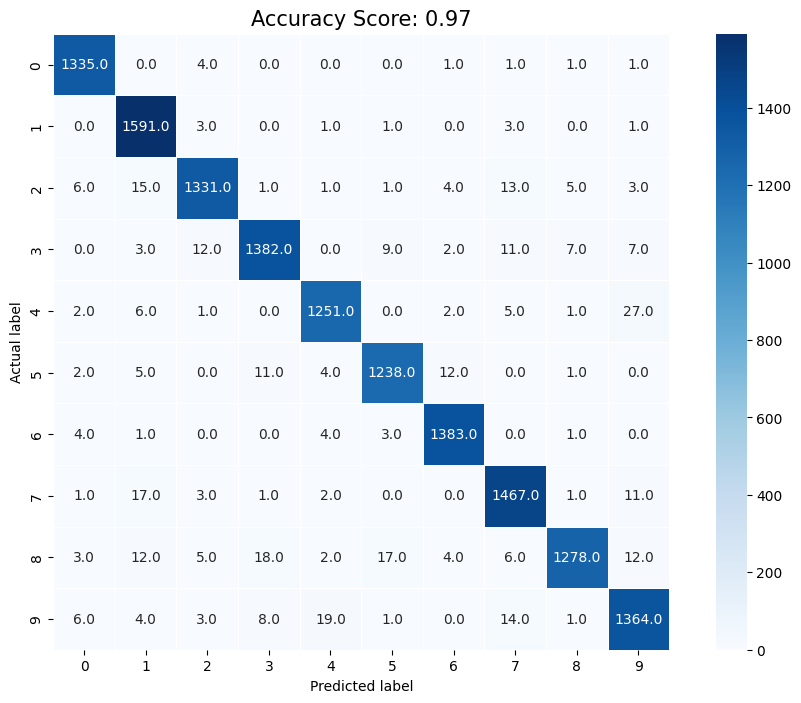

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print("accuracy: ", accuracy_score(y_test, y_pred), end="\n\n")
print("Classification Report: ")
print(classification_report(y_test, y_pred), end="\n\n")
plot_confusion_matrix(
    y_test, y_pred, accuracy=accuracy_score(y_test, y_pred), is_save=False
)


# Problem 2
Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

(You can use the shift() function from the scipy.ndimage.interpolation module. For example, shift(image, [2, 1], cval=0) shifts the image 2 pixels down and 1 pixel to the right.)

In [7]:
# 定义一个转换函数
import numpy as np
import pandas as pd
from typing import Literal
from scipy.ndimage import shift

def shift_image(
        image: pd.Series, 
        direction: Literal["left", "right", "up", "down"]
) -> np.ndarray:
    
    image: np.ndarray = image.values.reshape(28, 28)
    if direction == 'left':
        image = shift(image, [-1, 0], cval=0)
    elif direction == 'right':
        image = shift(image, [1, 0], cval=0)
    elif direction == 'up':
        image = shift(image, [0, -1], cval=0)
    elif direction == 'down':
        image = shift(image, [0, 1], cval=0)
    else:
        raise ValueError("Invalid direction")
    return image.flatten()

In [8]:
# 扩展训练集
import pandas as pd

# 准备收集新生成的图像和对应标签
new_images = []
new_labels = []

for i in range(len(X_train)):
    # 移动图像
    left_image = shift_image(X_train.iloc[i], "left")
    right_image = shift_image(X_train.iloc[i], "right")
    up_image = shift_image(X_train.iloc[i], "up")
    down_image = shift_image(X_train.iloc[i], "down")
    
    # 加入图像到列表
    new_images.extend([left_image, right_image, up_image, down_image])
    
    # 复制当前图像的标签四次（每个方向一个）
    label = y_train.iloc[i]
    new_labels.extend([label, label, label, label])

    # 更新进度条显示
    print("Loading...", 
          f'|{"■" * ((i + 1) * 50 // len(X_train)):50}|', 
          f'{(i + 1) * 100 // len(X_train)}%', end='\r')

# 将新图像和新标签转换为DataFrame
new_images_df = pd.DataFrame(new_images, columns=X_train.columns)
new_labels_df = pd.DataFrame(new_labels)

# 合并原始数据和新数据
X_train_shift = pd.concat([X_train, new_images_df], ignore_index=True)
y_train_shift = pd.concat([y_train, new_labels_df], ignore_index=True)

print("\nDone")
# 显示扩展后的数据集形状
print(X_train_shift.shape)
print(y_train_shift.shape)


Loading... |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100%
Done
(280000, 784)
(280000, 1)


In [9]:
# 使用扩展的训练集进行训练
y_train_shift = y_train_shift.values.ravel()
shifted_model = best_knclassifer.fit(X_train_shift, y_train_shift)

In [10]:
# 使用新模型进行预测
y_pred_new = shifted_model.predict(X_test)

accuracy:  0.9798571428571429

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1343
           1       0.97      1.00      0.98      1600
           2       0.99      0.97      0.98      1380
           3       0.98      0.98      0.98      1433
           4       0.98      0.97      0.98      1295
           5       0.99      0.98      0.98      1273
           6       0.99      0.99      0.99      1396
           7       0.97      0.98      0.98      1503
           8       0.99      0.95      0.97      1357
           9       0.96      0.97      0.97      1420

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000


Confusion Matrix:
 [[1338    0    1    0    0    0    2    1    1    0]
 [   0 1595    0    0    1    0    0    2    0    2]
 [   6   12 1342    1    1    0    1   17    0    0]
 [   0 

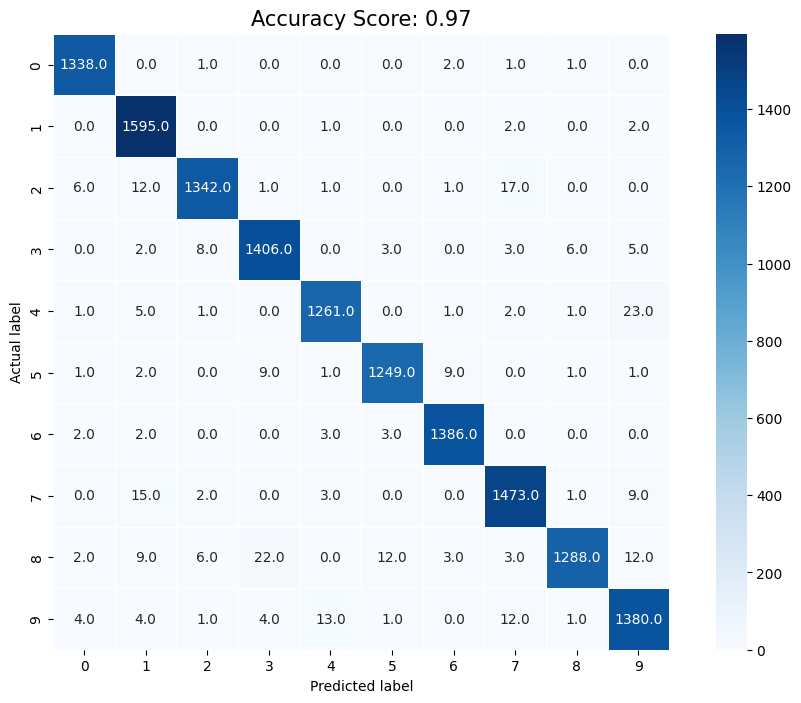

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print("accuracy: ", accuracy_score(y_test, y_pred_new), end="\n\n")
print("Classification Report: ")
print(classification_report(y_test, y_pred_new), end="\n\n")
plot_confusion_matrix(
    y_test, y_pred_new, accuracy=accuracy_score(y_test, y_pred), is_save=False
)